In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

from sklearn.preprocessing import StandardScaler

sns.set_style("whitegrid")

In [2]:
# Импортируйте библиотеку pandas
import pandas as pd

# Прочитайте данные из файлов
df1 = pd.read_csv('data_01.csv')
df2 = pd.read_csv('data_02.csv')
df3 = pd.read_csv('data_03.csv')
df4 = pd.read_csv('data_04.csv')
df5 = pd.read_csv('data_05.csv')
df6 = pd.read_csv('data_06.csv')

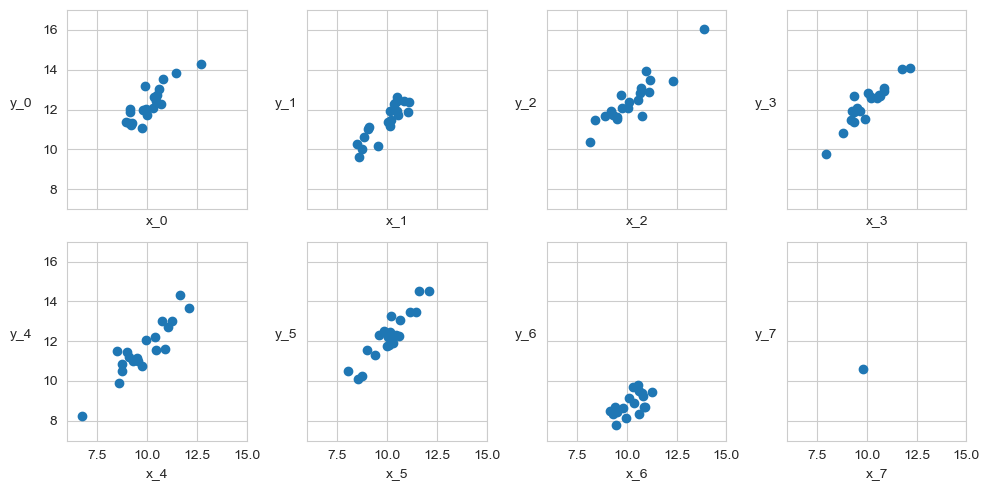

In [3]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(42)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N
plt.tight_layout()

In [4]:


# Вычислите средние значения по колонкам 'x' и 'y' для каждого DataFrame
mean_x_df1 = df1['x'].mean()
mean_y_df1 = df1['y'].mean()

mean_x_df2 = df2['x'].mean()
mean_y_df2 = df2['y'].mean()

mean_x_df3 = df3['x'].mean()
mean_y_df3 = df3['y'].mean()

mean_x_df4 = df4['x'].mean()
mean_y_df4 = df4['y'].mean()

mean_x_df5 = df5['x'].mean()
mean_y_df5 = df5['y'].mean()

mean_x_df6 = df6['x'].mean()
mean_y_df6 = df6['y'].mean()

# Теперь у вас есть средние значения по колонкам 'x' и 'y' для каждого DataFrame


In [5]:
# Создайте списки для средних значений x и y
x_m = np.mean([mean_x_df1, mean_x_df2, mean_x_df3, mean_x_df4, mean_x_df5, mean_x_df6])
y_m = np.mean([mean_y_df1, mean_y_df2, mean_y_df3, mean_y_df4, mean_y_df5, mean_y_df6])

# Теперь у вас есть один вектор x_m и один вектор y_m, содержащие средние значения


In [6]:
datasets = [df1, df2, df3, df4, df5, df6]

all_data = pd.concat(datasets, keys=range(len(datasets)))

def remove_outliers_iqr(df, columns, lower_bound=0.25, upper_bound=0.75):
    def remove_outliers(column):
        Q1 = df[column].quantile(lower_bound)
        Q3 = df[column].quantile(upper_bound)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        return df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]

    df_no_outliers = df.copy()
    for column in columns:
        df_no_outliers = remove_outliers(column)

    return df_no_outliers

# Указать столбцы, из которых вы хотите удалить выбросы
columns_to_remove_outliers = ['x', 'y']

# Применить функцию для каждого из DataFrame
df1 = remove_outliers_iqr(df1, columns_to_remove_outliers)
df2 = remove_outliers_iqr(df2, columns_to_remove_outliers)
df3 = remove_outliers_iqr(df3, columns_to_remove_outliers)
df4 = remove_outliers_iqr(df4, columns_to_remove_outliers)
df5 = remove_outliers_iqr(df5, columns_to_remove_outliers)
df6 = remove_outliers_iqr(df6, columns_to_remove_outliers)


all_data['x'] = all_data.x - all_data.x.mean()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [α_tmp, β, ε, ν]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


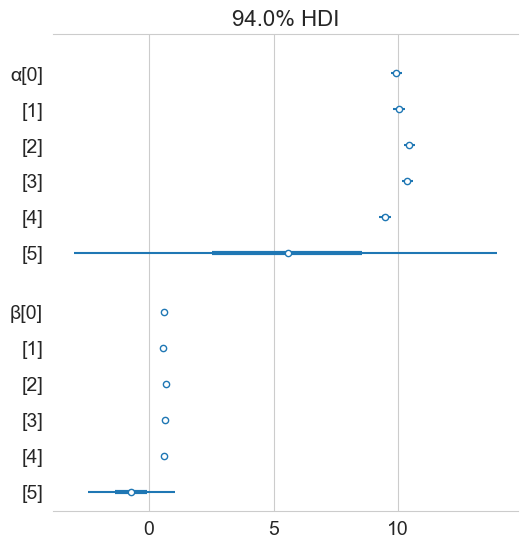

In [7]:


all_data['dataset_idx'] = np.repeat(range(len(datasets)), [len(df) for df in datasets])

M = len(datasets)
N = len(all_data)

with pm.Model() as unpooled_model:
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10, shape=M)
    β = pm.Normal('β', mu=0, sigma=10, shape=M)
    ε = pm.HalfCauchy('ε', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[all_data['dataset_idx']] + β[all_data['dataset_idx']] * all_data['x'].values,
                         sigma=ε, nu=ν, observed=all_data['y'].values)

    α = pm.Deterministic('α', α_tmp - β * all_data.groupby('dataset_idx').mean()['x'].values)

    trace_up = pm.sample(2000, tune=1000, target_accept=0.8)

az.plot_forest(trace_up, var_names=['α', 'β'], combined=True);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [α_μ_tmp, α_σ_tmp, β_μ, β_σ, α_tmp, β, ε, ν]


Sampling 2 chains for 1_000 tune and 750 draw iterations (2_000 + 1_500 draws total) took 93 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


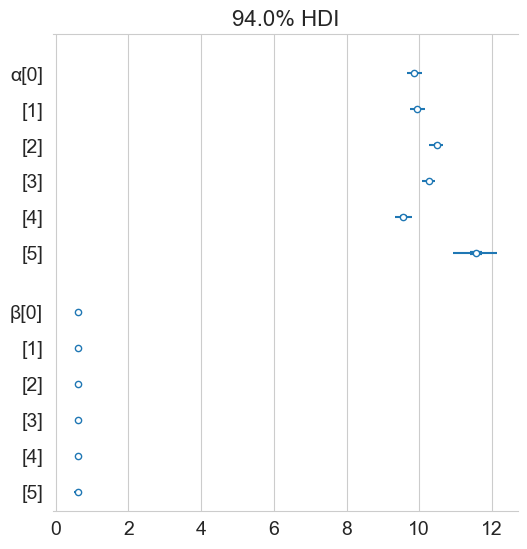

In [8]:
with pm.Model() as hierarchical_model:
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sigma=4)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', sigma=2)
    β_μ = pm.Normal('β_μ', mu=0, sigma=2)
    β_σ = pm.Normal('β_σ', sigma=2)

    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sigma=α_σ_tmp, shape=len(datasets))
    β = pm.Normal('β', mu=β_μ, sigma=β_σ, shape=len(datasets))
    ε = pm.HalfCauchy('ε', 2)
    ν = pm.Normal('ν', 1/13)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[all_data['dataset_idx']] + β[all_data['dataset_idx']] * all_data['x'].values,
                         sigma=ε, nu=ν, observed=all_data['y'].values)

    α = pm.Deterministic('α', α_tmp - β * all_data.groupby('dataset_idx').mean()['x'].values)
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * all_data.groupby('dataset_idx').mean()['x'].values)
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * all_data.groupby('dataset_idx').mean()['x'].values)

    trace_hm = pm.sample(750, target_accept=0.95, chains=2, cores =4)

# Отобразите результаты
az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True);

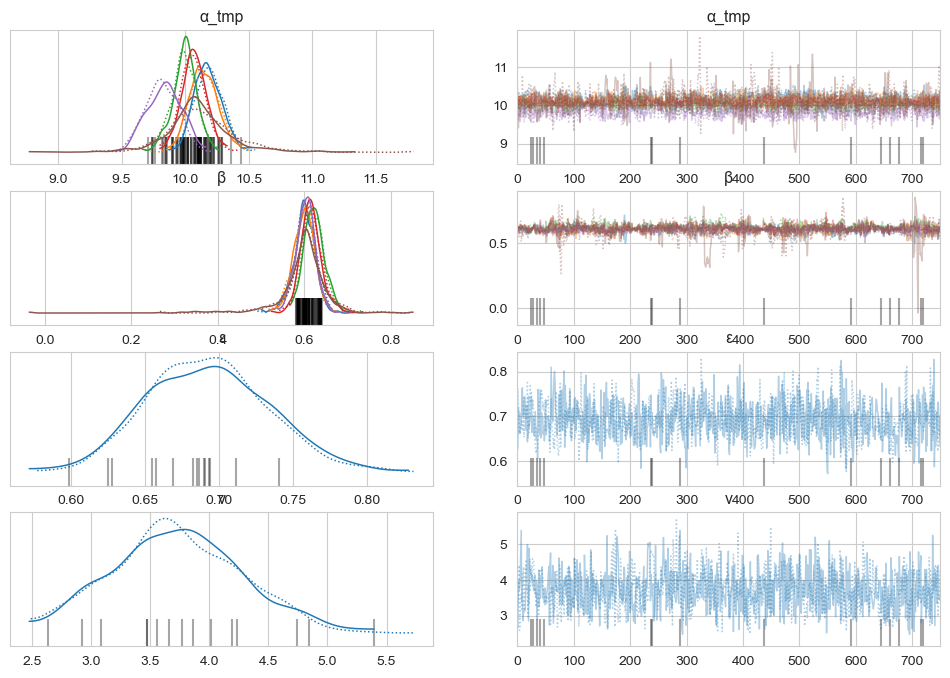

In [9]:
varnames = ['α_tmp', 'β', 'ε', 'ν'];
az.plot_trace(trace_hm, varnames);

In [10]:
az.summary(trace_hm)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_μ_tmp,10.044,0.136,9.757,10.268,0.005,0.004,760.0,572.0,1.01
β_μ,0.607,0.028,0.559,0.655,0.002,0.001,311.0,332.0,1.01
β_σ,0.034,0.040,0.002,0.088,0.004,0.003,92.0,177.0,1.00
α_tmp[0],10.184,0.109,9.992,10.391,0.004,0.003,761.0,1052.0,1.00
α_tmp[1],10.149,0.112,9.944,10.357,0.004,0.003,690.0,1115.0,1.00
α_tmp[2],9.994,0.098,9.804,10.179,0.003,0.002,1252.0,1079.0,1.00
α_tmp[3],10.066,0.097,9.872,10.241,0.003,0.002,1175.0,860.0,1.00
α_tmp[4],9.825,0.131,9.569,10.044,0.006,0.004,507.0,882.0,1.01
α_tmp[5],10.117,0.276,9.683,10.733,0.011,0.008,786.0,604.0,1.00
β[0],0.600,0.026,0.551,0.649,0.001,0.001,567.0,505.0,1.00


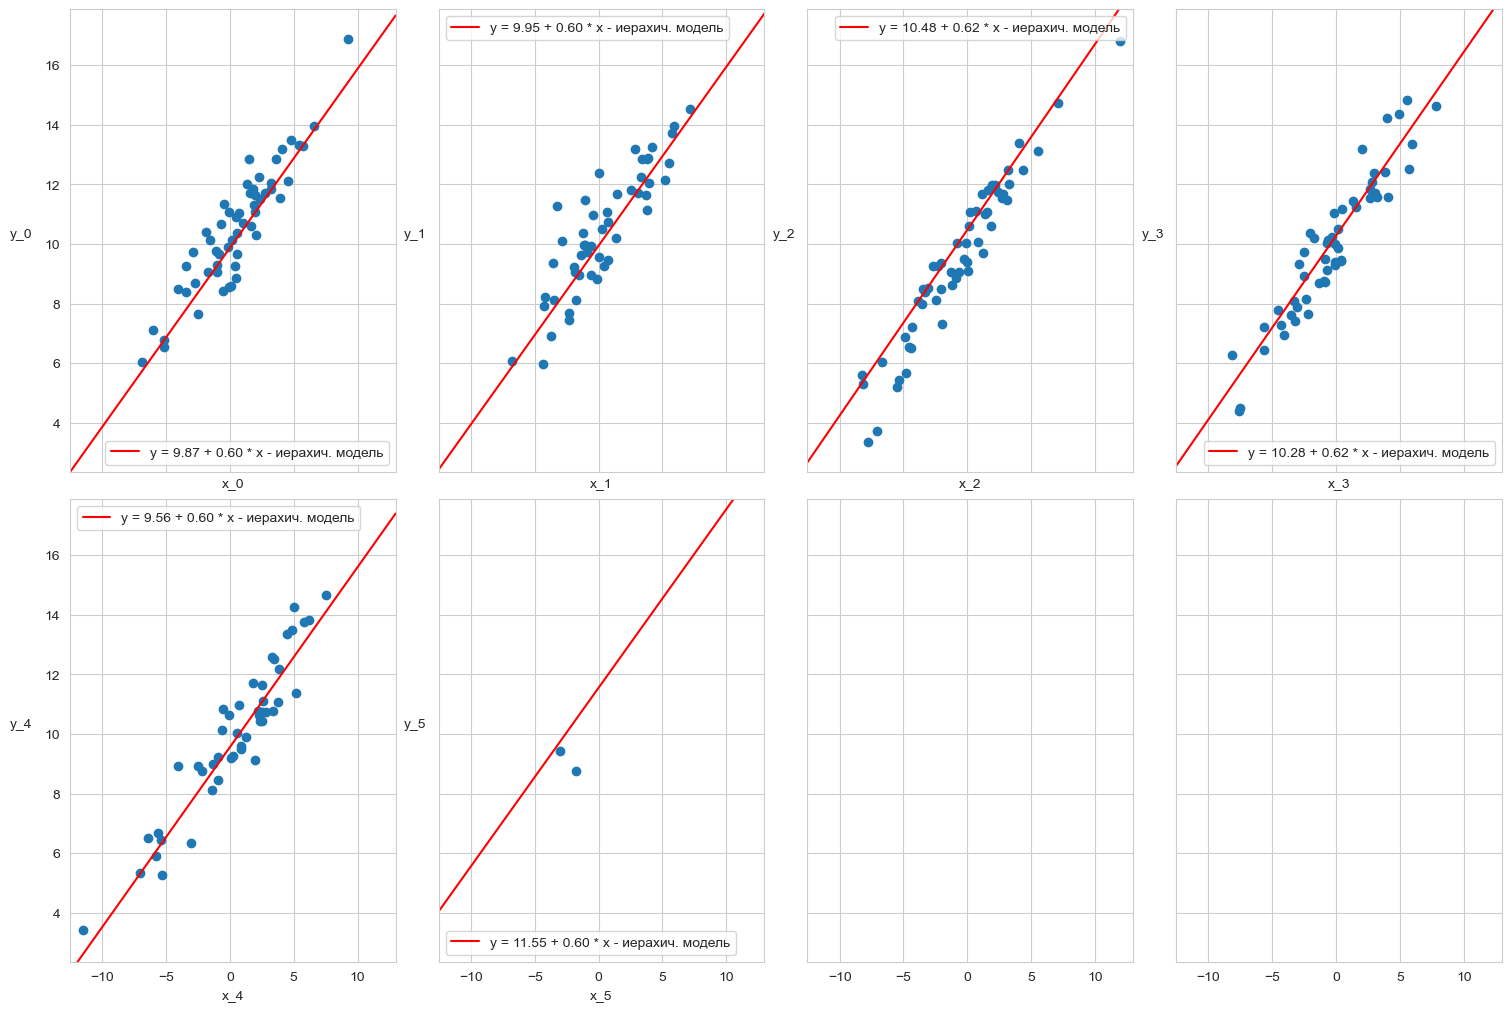

In [11]:
_, ax = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True, constrained_layout=True)

trace_hmm = trace_hm.posterior.stack(samples={"chain", "draw"})

ax = np.ravel(ax)
j, k = 0, 6
x_range = np.linspace(all_data['x'].min() - 1, all_data['x'].max() + 1, 10)

for i in range(6):
    ax[i].scatter(all_data[all_data['dataset_idx'] == i]['x'], all_data[all_data['dataset_idx'] == i]['y'])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)

    # Получите средние значения параметров из трассировки
    alpha_hmm = trace_hmm['α'].sel({'α_dim_0': i}).mean().item()
    beta_hmm = trace_hmm['β'].sel({'β_dim_0': i}).mean().item()

    ax[i].plot(x_range, alpha_hmm + beta_hmm * x_range, c='r', label=f'y = {alpha_hmm:.2f} + {beta_hmm:.2f} * x' + ' - иерахич. модель')

    ax[i].legend()
    plt.xlim(all_data['x'].min() - 1, all_data['x'].max() + 1)
    plt.ylim(all_data['y'].min() - 1, all_data['y'].max() + 1)